## Lattice dynamics - anharmonicity
---

In this notebook we will continue the calculations from the previous exercise ( [Lattice Dynamics](08_Lattice_Dynamics.ipynb) ) and perform the calculation of *anharmonic* lattice dynamics of the 3C-SiC crystal - still using *finite displacements* (or *direct*) method. This type of calculation is much more challenging, thus we will need to make even more compromises to keep the run time under control. 
Thus, the results are less accurate in comparison to the harmonic part of the tutorial. On the other hand one needs to remember that these types of calculations are close to the state of the art in the field and have been developed during last decade. Thus, it should be expected that they typically require more then 10 minutes of calculation on the free computing resource.

Nevertheless, the following calculation can be scaled up to be fully valid analysis by appropriate adjustment of its parameters. Including but not limited to:
- energy cutoff,
- reciprocal space sampling grids,
- supercell size
- number of displacements
- interaction range for higher orders of approximation

### Calculation setup

In [1]:
%pylab inline
import ase
import ase.io
from ase.build import bulk
from ase.calculators.abinit import Abinit
from ase import units as un
from elastic import get_pressure

# Utility functions
from tqdm.auto import tqdm
from abilib import scan_param, set_params

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
a = 4.38120844
prim = bulk('SiC', crystalstructure='zincblende', a=a, cubic=False)

In [3]:
work_dir = 'work_09'

In [4]:
def create_calculator(directory=work_dir, ecut=350):
    return Abinit(directory=directory,
              ecut= ecut,
              pps = 'pawxml', pawecutdg = 750, xc = 'GGA',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=1,
              shiftk=[[0.5, 0.5, 0.5]],
              chksymbreak=0,
              )

In [5]:
calc = create_calculator()
prim.calc = calc

In [6]:
print(f'  Energy:  {prim.get_potential_energy():.3f} eV')
print( '  Stress: [', 6*' %6.2f' % tuple(prim.get_stress()/un.GPa), '] GPa')
print(f'Pressure:     {get_pressure(prim.get_stress())/un.GPa:.3f} GPa')

  Energy:  -265.100 eV
  Stress: [    2.49   2.49   2.49   0.00   0.00   0.00 ] GPa
Pressure:     -2.491 GPa


### Convergence scan
---
This is a reminder that you should *always* perform convergence analysis of your calculations. We can skip this step by setting `Scan_Corvengence = False` , since we have already performed this analysis in previous part.

In [7]:
Scan_Corvengence = False

In [8]:
if Scan_Corvengence :
    ecut = prim.calc.parameters['ecut']
    ecuts, eres = scan_param(prim, 'ecut', 300, 500)

    figsize(6,6)
    subplot(211)
    plot(ecuts, eres[0], 'o')
    ylabel('Energy (eV)')
    subplot(212)
    plot(ecuts, eres[1]/un.GPa, 'o')
    ylabel('Pressure (GPa)')
    xlabel('ecut (eV)');
    prim.calc = set_params(prim.calc, ecut=ecut)

### Basic structure calculation

---


In [9]:
cryst = bulk('SiC', crystalstructure='zincblende', a=a, cubic=True)
cryst = ase.build.sort(cryst, tags=cryst.get_atomic_numbers())
cryst.calc = create_calculator(f'{work_dir}/UC')

In [10]:
cryst.get_forces()

array([[-0., -0., -0.],
       [ 0.,  0.,  0.],
       [-0., -0., -0.],
       [ 0., -0., -0.],
       [-0., -0.,  0.],
       [-0., -0.,  0.],
       [-0.,  0., -0.],
       [-0., -0.,  0.]])

### Generate displacements and calculate forces
---

This time we calculate phonons for several sizes of displacement to investigate the amplitude-frequency relation.

In [11]:
dsp={}
N = 1
for dev in 1, 6, 8, 10: # deviation in pm
    dsp[dev]={}
    for n in range(N):
        dsp[dev][n] = ase.Atoms(cryst)
        dsp[dev][n].calc = create_calculator(f'{work_dir}/dsp_{dev}_{n}')
        dsp[dev][n].rattle(stdev=dev/100)

In [12]:
for dev in dsp:
    print(f"Displacement: {dev} pm")
    with open(f'{work_dir}/DFSET_{dev}', 'wt') as dfset:
        # Iterate over structures
        for n, s in tqdm(dsp[dev].items()):
            # Write data to DFSET file
            savetxt(dfset,
                    # Generate list of displacement - force records:
                    # dx dy dz fx fy fz
                    # for each atom and each structure
                    # Units for ALAMODE: Bohr and Rydberg/Bohr !
                    [list(x/un.Bohr)+list(f/(un.Rydberg/un.Bohr)) 
                        for x, f in zip(s.get_positions()-cryst.get_positions(), 
                                        s.get_forces()) ],
                    fmt="%14.8f", 
                    header=f'Sample: {n:5}  Energy: {s.get_potential_energy():.4f} eV')

Displacement: 1 pm


  0%|          | 0/1 [00:00<?, ?it/s]

Displacement: 6 pm


  0%|          | 0/1 [00:00<?, ?it/s]

Displacement: 8 pm


  0%|          | 0/1 [00:00<?, ?it/s]

Displacement: 10 pm


  0%|          | 0/1 [00:00<?, ?it/s]

### Building higher-order interaction model
---
Here we fit a higher-order interaction model (third order by default) based on the displacement-force relation. The interaction range must be kept low to limit the number of independent force constants and the size of the required data set.

In [13]:
# Write supercell data in VASP format file
ase.io.write(f'{work_dir}/POSCAR', cryst, vasp5=True, direct=True)

In [14]:
for dev in dsp:
    !echo "Displacement: {dev} pm"
    # Prepare fitting input files
    !./make-am-files.py -p 3C-SiC-{dev} -n {work_dir}/POSCAR \
        -f DFSET_{dev} -o 2 --c2 5 opt > {work_dir}/alm_fit_{dev}.in
    # Prepare phonon input files
    !./make-am-files.py -p 3C-SiC-{dev} -n {work_dir}/POSCAR \
        -k 3C-SiC.path -b 3 -c ../3C-SiC phon > {work_dir}/alm_ph_{dev}.in
    # Fit
    !(cd {work_dir} ; alm alm_fit_{dev}.in > alm_fit_{dev}.log ; tail alm_fit_{dev}.log)
    # Calculate phonons
    !(cd {work_dir} ; anphon alm_ph_{dev}.in > alm_ph_{dev}.log ; tail alm_ph_{dev}.log)

Displacement: 1 pm

 -------------------------------------------------------------------

 The following files are created:

 Force constants in a human-readable format : 3C-SiC-1.fcs
 Input data for the phonon code ANPHON      : 3C-SiC-1.xml

 Job finished at Sat Dec  7 23:00:34 2024



 -----------------------------------------------------------------

 The following files are created: 
  3C-SiC-1.bands       : Phonon band structure
  3C-SiC-1.band.evec   : Eigenvector of all k points

 Job finished at Sat Dec  7 23:00:35 2024

Displacement: 6 pm

 -------------------------------------------------------------------

 The following files are created:

 Force constants in a human-readable format : 3C-SiC-6.fcs
 Input data for the phonon code ANPHON      : 3C-SiC-6.xml

 Job finished at Sat Dec  7 23:00:39 2024



 -----------------------------------------------------------------

 The following files are created: 
  3C-SiC-6.bands       : Phonon band structure
  3C-SiC-6.band.evec   : 

### Phonon calculation with ALAMODE
---
Visualization of the phonon dispersion relations illustrating the changes in phonon frequencies with respect to amplitudes.

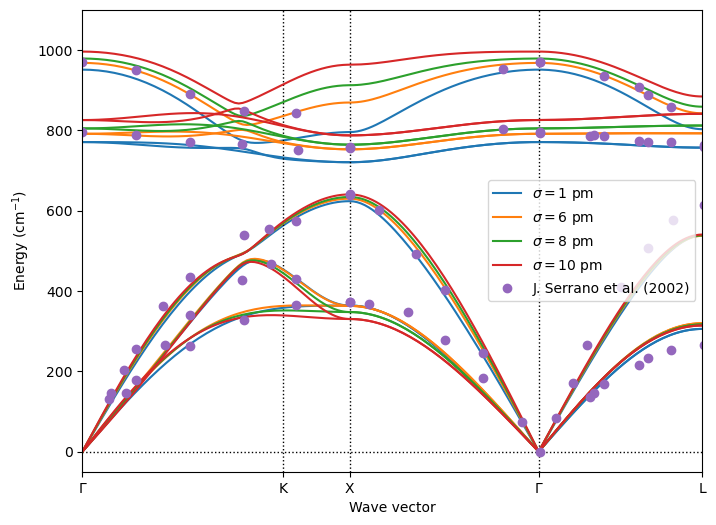

In [15]:
# Make a comparison...
figsize(8,6)

for n, dev in enumerate(dsp):
    fn = f'{work_dir}/3C-SiC-{dev}.bands'
        
    # Load and plot the data
    d = loadtxt(fn).T
    plot(d[0], d[1].T, color=f'C{n}', ls='-', label=f'$\\sigma={dev}$ pm')
    plot(d[0], d[2:].T, color=f'C{n}', ls='-')[0]
    
    if n==0:
        # Read the metadata from the header
        with open(fn, 'r') as df:
            for i, l in enumerate(df):
                if i==0:
                    nm = [n.replace('G','$\\Gamma$') for n in l.split()[1:]]
                elif i==1:
                    pos = [float(x) for x in l.split()[1:]]
                else :
                    break
            pnts = [nm,pos]

        # Sugar-coating
        xlim(pnts[1][0], pnts[1][-1])
        ylim(bottom=-50, top=1100)
        axhline(ls=":", lw=1, color='k')
        gca().set_xticks(pnts[1])
        gca().set_xticklabels(pnts[0])
        for xx in pnts[1][1:-1]:
            axvline(xx, ls=':', lw=1, color='k')




ylabel('Energy (cm$^{-1}$)')
xlabel('Wave vector')

    # Compare with experiment
ex = loadtxt('data/serrano.dat').T
plot(ex[0], ex[1], 'o', color='C4', label='J. Serrano et al. (2002)')
legend()

    
# Save it for posterity
savefig('SiC_anh_phonons.pdf');

#### Generate remaining ALAMODE input files
---
The phonon lifetime and heat conductivity is calculated with anphon program and its analysis tool `analyze_phonons.py`. The most time consuming part is the solution of Boltzmann Transport Equation (BTE) with Relaxation Time Approximation (RTA). This part is performed by specially optimized version of the `anphon` program. The results are post-processed by the `analyze_phonons.py` program.

In [16]:
!analyze_phonons.py --help

Usage: analyze_phonons.py [options]

Options:
  -h, --help            show this help message and exit
  --temp=TEMP           target temperature to analyze
  --mode=MODE           specify phonon mode index to print
  --kpoint=KPOINT       specify k-point index to print
  --calc=tau|kappa|cumulative|cumulative2|kappa_boundary
                        specify what to print. Available options are tau
                        (Lifetime, mean-free-path, etc.), kappa (Thermal
                        conductivity), cumulative (Cumulative thermal
                        conductivity), cumulative2 (Cumulative thermal
                        conductivity with specific xyz-directions), and
                        kappa_boundary (Thermal conductivity with boundary
                        effect). When --calc=cumulative2, please specify the
                        --direction option. When --calc=kappa_boundary, please
                        specify the --size option.
  --isotope=PREFIX.self_isotope


In [17]:
grid = 5
new_run = True
for dev in dsp:
    !echo "Displacement: {dev} pm"
    # Prepare phonon lifetime input files
    !./make-am-files.py -p 3C-SiC-{dev} -n {work_dir}/POSCAR \
        -g {grid}x{grid}x{grid} -b 3 -c ../3C-SiC rta > {work_dir}/alm_rta_{dev}.in
    # Remove restart file
    if new_run :
        !(cd {work_dir} ; rm -f 3C-SiC-{dev}.result )
    # Calculate phonon lifetimes
    !(cd {work_dir} ; anphon alm_rta_{dev}.in > alm_rta_{dev}.log ; tail alm_rta_{dev}.log)

Displacement: 1 pm
 MODE    82 done.
 MODE    83 done.
 MODE    84 done.

 -----------------------------------------------------------------

 Lattice thermal conductivity is stored in the file 3C-SiC-1.kl

 Job finished at Sat Dec  7 23:01:04 2024

Displacement: 6 pm
 MODE    82 done.
 MODE    83 done.
 MODE    84 done.

 -----------------------------------------------------------------

 Lattice thermal conductivity is stored in the file 3C-SiC-6.kl

 Job finished at Sat Dec  7 23:01:13 2024

Displacement: 8 pm
 MODE    82 done.
 MODE    83 done.
 MODE    84 done.

 -----------------------------------------------------------------

 Lattice thermal conductivity is stored in the file 3C-SiC-8.kl

 Job finished at Sat Dec  7 23:01:22 2024

Displacement: 10 pm
 MODE    82 done.
 MODE    83 done.
 MODE    84 done.

 -----------------------------------------------------------------

 Lattice thermal conductivity is stored in the file 3C-SiC-10.kl

 Job finished at Sat Dec  7 23:01:32 2024

In [18]:
for dev in dsp:
    !echo "Displacement: {dev} pm"
    # Analyze the results
    # Lifetimes
    !(cd {work_dir} ; analyze_phonons.py --calc tau --temp 500 3C-SiC-{dev}.result > 3C-SiC-{dev}_tau.dat )
    # Heat conductivity
    !(cd {work_dir} ; analyze_phonons.py --calc kappa_boundary --size 1.0e+4 3C-SiC-{dev}.result > 3C-SiC-{dev}_kappa.dat )

Displacement: 1 pm
Displacement: 6 pm
Displacement: 8 pm
Displacement: 10 pm


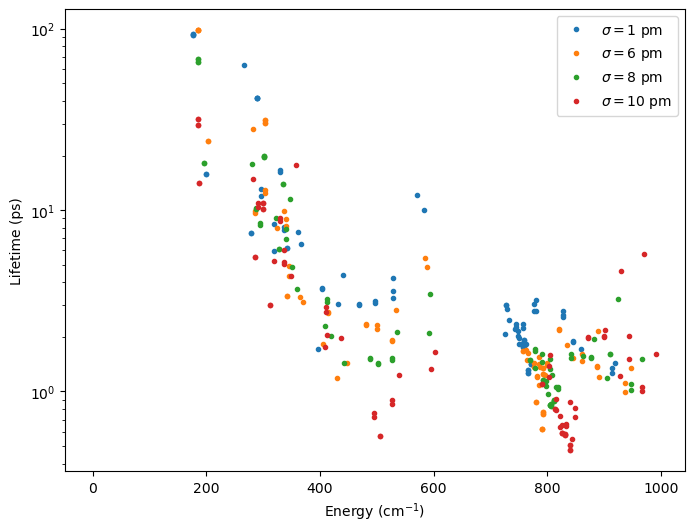

In [19]:
for dev in dsp:
    tau = loadtxt(f'{work_dir}/3C-SiC-{dev}_tau.dat').T
    semilogy(tau[2], tau[3], '.', label=f'$\\sigma={dev}$ pm')

xlabel('Energy (cm$^{-1}$)')
ylabel('Lifetime (ps)')
legend();

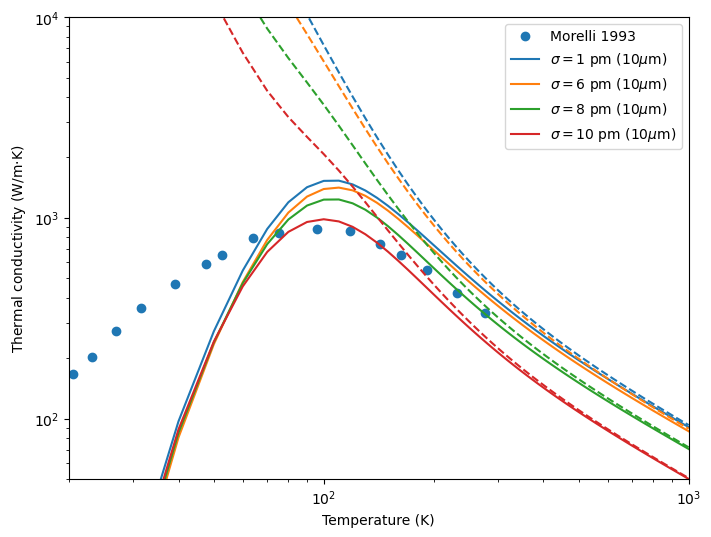

In [20]:
ex = loadtxt('data/morelli_1993_3C_SiC.dat').T
loglog(ex[0], ex[1]*100, 'o', label='Morelli 1993')
for n, dev in enumerate(dsp):
    tk = loadtxt(f'{work_dir}/3C-SiC-{dev}.kl').T
    tkb = loadtxt(f'{work_dir}/3C-SiC-{dev}_kappa.dat').T
    plot(tk[0], tk[1], '--', color=f'C{n}')
    plot(tkb[0], tkb[1], '-', color=f'C{n}', label=f'$\\sigma={dev}$ pm (10$\\mu$m)')

xlim(20,1000)
ylim(50, 10_000)
xlabel('Temperature (K)')
ylabel('Thermal conductivity (W/m$\\cdot$K)')
legend();